In [1]:
%matplotlib inline
import io

import cv2
import numpy as np
import PIL.Image

import image_transform as it

from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display

In [2]:
titles = [f"d00{i+1}.jpg" for i in range(5)]
images = [cv2.imread(f"data/{title}") for title in titles]
my_images = [cv2.imread(f"data/my_dataset/{title}") for title in titles]
result = cv2.imread(f"data/result.png")

def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    f = io.BytesIO()
    PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255)).save(f, "png")
    display(Image(data=f.getvalue()))

def cvconv(f: np.ndarray, g: np.ndarray) -> np.ndarray:
  pad_v, pad_h = ((np.array(g.shape) - 1) // 2)
  fb = cv2.copyMakeBorder(f, pad_v, pad_v, pad_h, pad_h, cv2.BORDER_CONSTANT, 0)
  fg_cv = cv2.filter2D(fb.astype(g.dtype), -1, g)

  return fg_cv[pad_v:fb.shape[0] - pad_v, pad_h:fb.shape[1] - pad_h]

In [3]:
changing_mask = it.extract_common_region(images, 15)

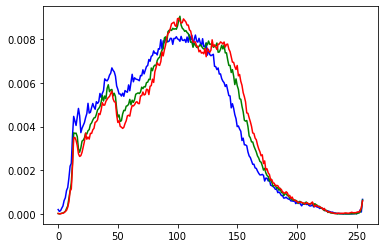

In [4]:
def create_image_histogram(image: np.ndarray) -> np.ndarray:
    histogram = np.zeros((256, 3), dtype=np.uint32)
    for i in range(3):
        histogram[:, i] = np.bincount(image[:, :, i].flatten(), minlength=256)
    return histogram

histograms = create_image_histogram(images[0]).T
densities = histograms / np.repeat(np.sum(histograms, axis=1), 256).reshape(3, 256)

plt.plot(densities[0], color="blue")
plt.plot(densities[1], color="green")
plt.plot(densities[2], color="red")
plt.show()

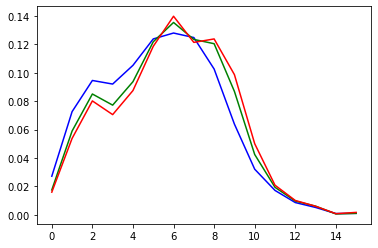

In [5]:
densities_binned = np.sum(densities.reshape(3, 16, 16), axis=2)
plt.plot(densities_binned[0], color="blue")
plt.plot(densities_binned[1], color="green")
plt.plot(densities_binned[2], color="red")
plt.show()

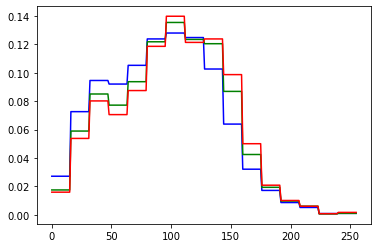

In [6]:
repeated_binned = np.repeat(densities_binned, 16, axis=1)
plt.plot(repeated_binned[0], color="blue")
plt.plot(repeated_binned[1], color="green")
plt.plot(repeated_binned[2], color="red")
plt.show()

In [7]:
def get_pixel_probabilities(image: np.ndarray) -> np.ndarray:
    histogram = create_image_histogram(image).T
    densities = histogram / np.repeat(np.sum(histogram, axis=1), 256).reshape(3, 256)
    pixel_probabilities = np.prod(densities[range(3), image], axis=2)
    return pixel_probabilities / np.max(pixel_probabilities)

def get_pixel_probabilities_all_histogram(image: np.ndarray, histogram: np.ndarray) -> np.ndarray:
    densities = histogram / np.repeat(np.sum(histogram, axis=1), 256).reshape(3, 256)
    pixel_probabilities = np.prod(densities[range(3), image], axis=2)
    return pixel_probabilities / np.max(pixel_probabilities)

def get_std_mask(image: np.ndarray) -> np.ndarray:
    std_img = np.var(np.array(image), axis=2)**0.5
    std_img = std_img / np.max(std_img)
    return std_img


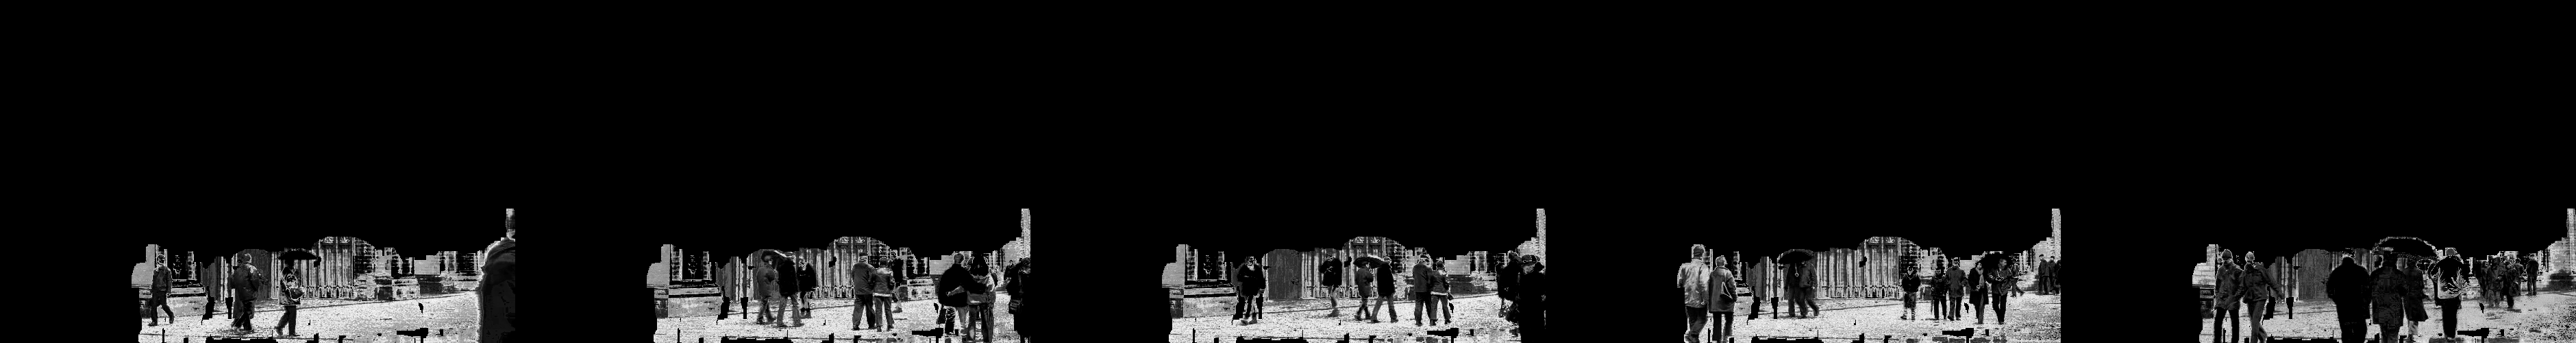

In [8]:
median_image = np.median(np.array(images), axis=0).astype(np.uint8)
weights = [get_pixel_probabilities(image) for image in images]
for weight, image in zip(weights, images):
    weight[:] = np.clip(weight - get_std_mask(image), 0, 1) 
    weight[changing_mask == 0] = 0

showarray(np.concatenate(weights, axis=1) * 255, None)
merged_1 = it.merge_use_max(images, weights)

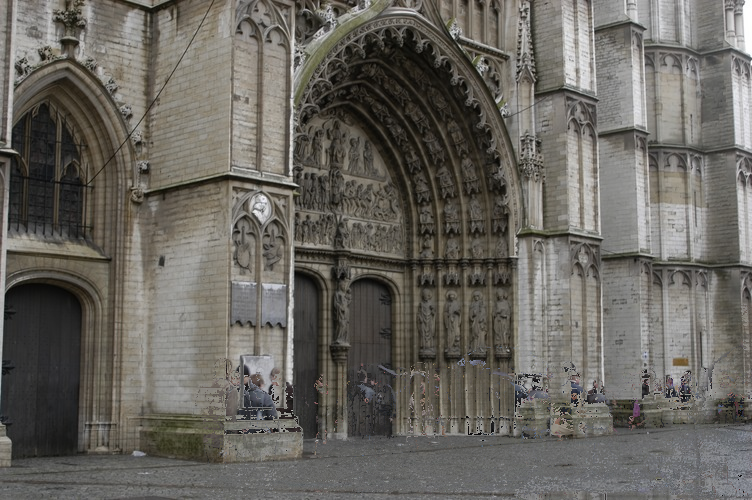

In [9]:
showarray(merged_1)

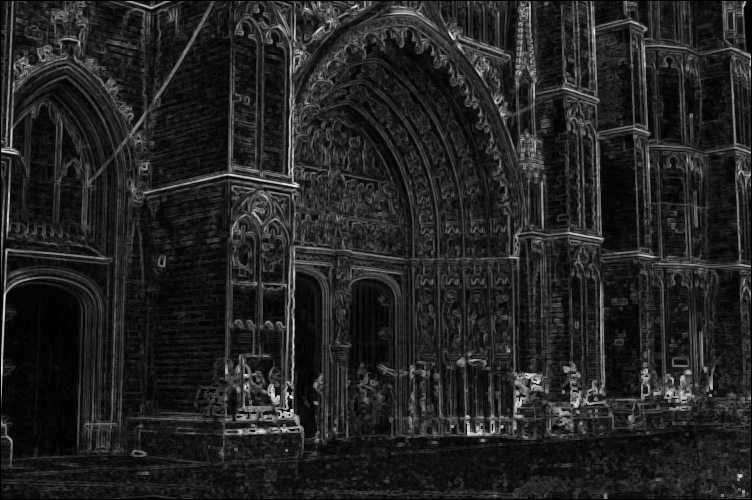

In [10]:
strided = np.lib.stride_tricks.sliding_window_view(merged_1, (3, 3, 3))
neighbor_variance = np.var(strided, axis=(2, 3, 4))
neighbor_variance = np.mean(neighbor_variance, axis=2)
neighbor_std = neighbor_variance**0.5
neighbor_std = neighbor_std / np.max(neighbor_std)
neighbor_std = np.pad(neighbor_std, 1, mode="constant", constant_values=0)
showarray(neighbor_std * 255, None)

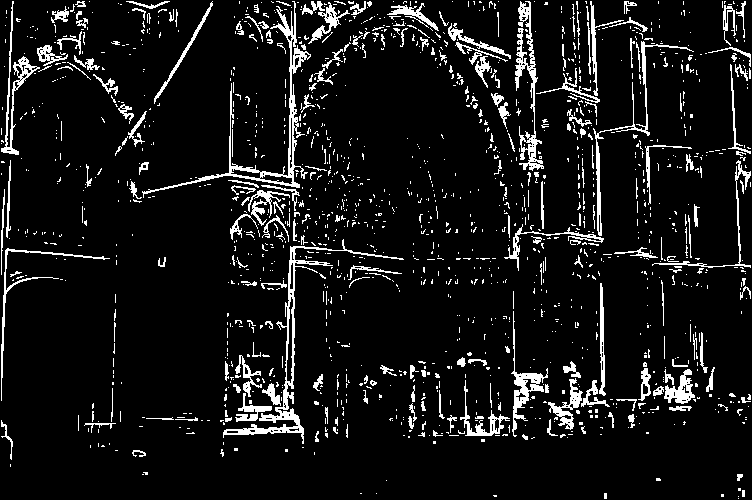

In [11]:
showarray((neighbor_std > 0.3) * 255, None)

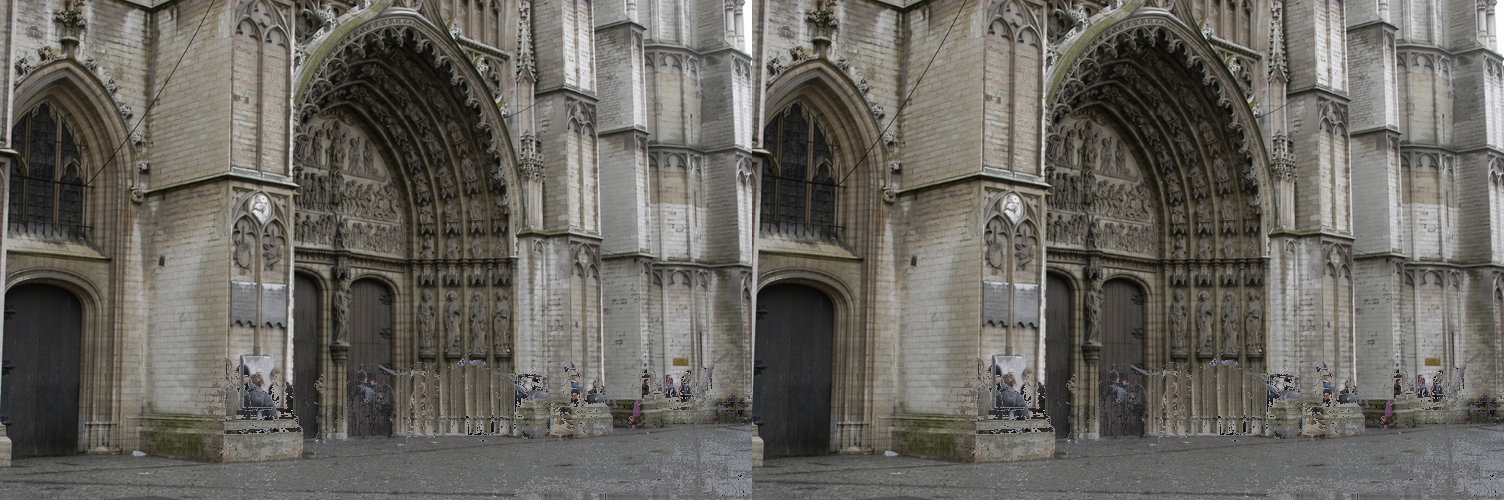

In [12]:
merged_enhanced = it.merge_use_max(images + [merged_1], weights + [neighbor_std])

showarray(np.concatenate([merged_1, merged_enhanced], axis=1))

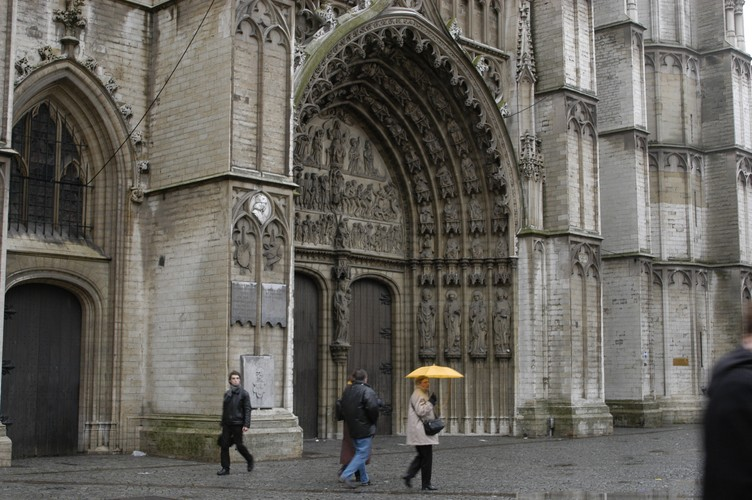

In [13]:
showarray(images[0])

In [14]:
def get_inverse_edge_mask(image: np.ndarray, changing_mask: np.ndarray) -> np.ndarray:
    edge_mask = cv2.Canny(image, 100, 300) / 255
    edge_mask = cv2.dilate(edge_mask, np.ones((3, 3)), iterations=1)
    edge_mask = cv2.blur(edge_mask, (3, 3))
    edge_mask[changing_mask == 0] = 0
    return 1 - edge_mask

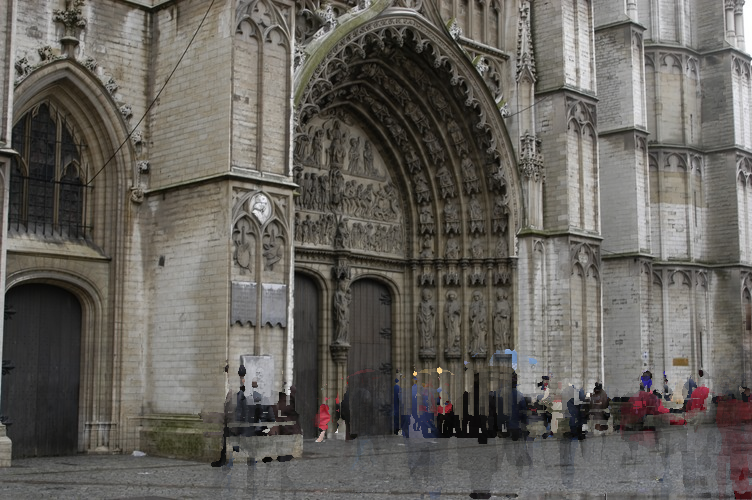

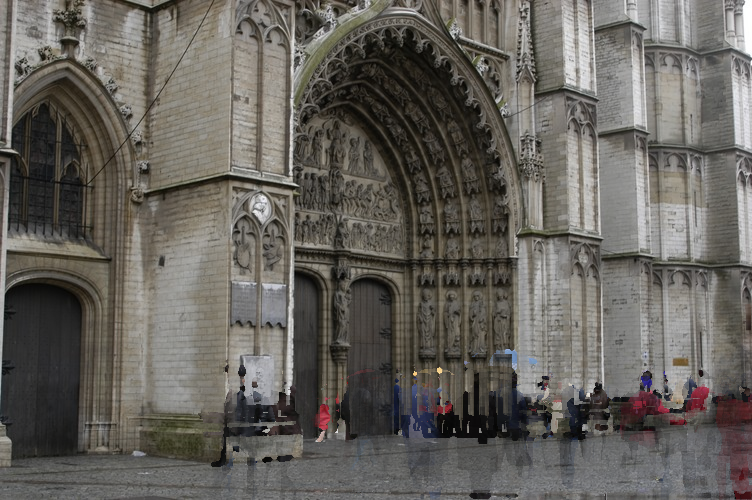

In [15]:
new_ims = images.copy()
new_ims.append(median_image)
new_ims.append(merged_1)
edge_weigths = [get_inverse_edge_mask(image, changing_mask) for image in new_ims]
edged_merged = it.merge_use_max(new_ims, edge_weigths)
showarray(edged_merged)
edge_weigths.append(get_inverse_edge_mask(edged_merged, changing_mask))
new_ims.append(edged_merged)
edged_merged = it.merge_use_max(new_ims, edge_weigths)
showarray(edged_merged)


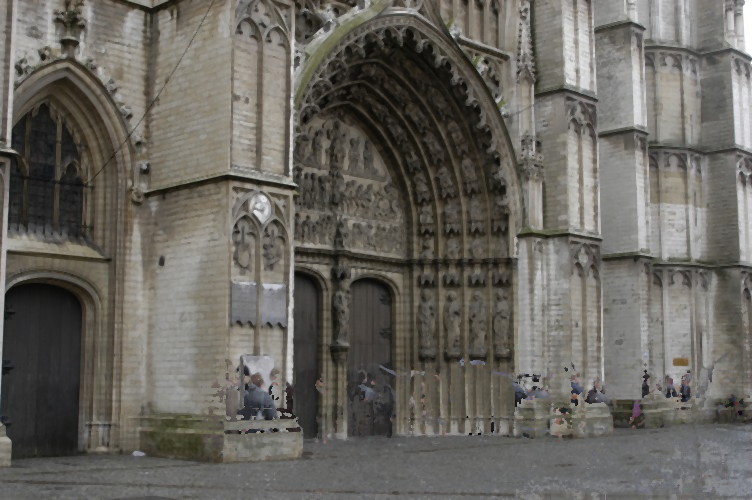

In [16]:
showarray(cv2.medianBlur(merged_1, 3))

In [18]:
def get_image_purity(image: np.ndarray) -> float:
    return ((cv2.Canny(image, 100, 300) / 255).sum() / np.prod(image.shape))

for image in images:
    print(get_image_purity(image))

print(get_image_purity(merged_1))

0.043233156028368795
0.04336170212765957
0.04376241134751773
0.04549113475177305
0.0439468085106383
0.04232003546099291


In [45]:
from itertools import product

merged_copied = merged_1.copy()
merged_purity = get_image_purity(merged_copied)
changing_domain = np.argwhere((changing_mask == 255) & (neighbor_std > 0.3))
gridded_domain = []
replacement_span = 4
for x, y in changing_domain:
    purities = []
    for image in images:
        merged_copied[x:x+replacement_span, y:y+replacement_span] = image[x:x+replacement_span, y:y+replacement_span]
        purities.append(get_image_purity(merged_copied))
    if np.max(purities) > merged_purity:
        merged_copied[x:x+replacement_span, y:y+replacement_span] = merged_1[x:x+replacement_span, y:y+replacement_span]
        continue
    best_image = np.argmax(purities)
    merged_purity = np.max(purities)
    merged_copied[x:x+replacement_span, y:y+replacement_span] = images[best_image][x:x+replacement_span, y:y+replacement_span]

KeyboardInterrupt: 

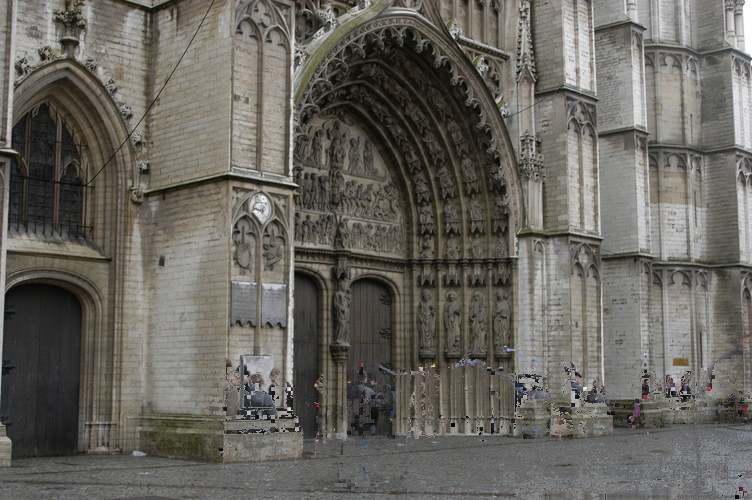

In [44]:
showarray(merged_copied)

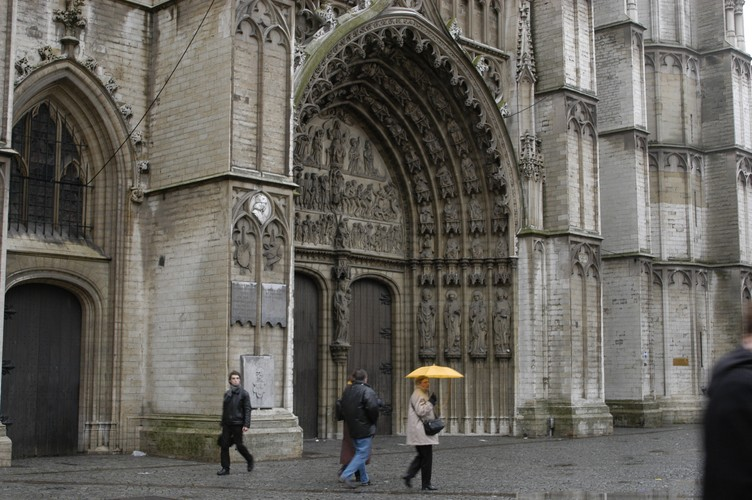

In [449]:
showarray(images[0])